In [83]:
import torch 
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import torch.nn.functional as F
import matplotlib.pylab as plt
import numpy as np
import random
import time
from torch.utils.data.dataloader import default_collate
from datetime import datetime
from joblib import dump, load
from csv import writer
import csv
import os

# FUNCTIONS

## PLOT FUNCTIONS

In [84]:
def plot_accuracy_loss(training_results): ## affiche la loss du training et ed l'entrainement
    plt.subplot(2, 1, 1)
    plt.plot(training_results['training_loss'], 'r')
    plt.ylabel('loss')
    plt.title('training loss iterations')
    plt.subplot(2, 1, 2)
    plt.plot(training_results['validation_loss'])
    plt.ylabel('validation loss')
    plt.xlabel('epochs')   
    plt.show()
    
# Define a function to plot model parameters

def print_model_parameters(model): 
    count = 0
    for ele in model.state_dict():
        count += 1
        if count % 2 != 0:
            print ("The following are the parameters for the layer ", count // 2 + 1)
        if ele.find("bias") != -1:
            print("The size of bias: ", model.state_dict()[ele].size())
        else:
            print("The size of weights: ", model.state_dict()[ele].size())
            

## affiche à l'époque considérée les différents éléments du modèle, 
#le tenseur
#la matrice de sampling actuelle et celle qui serait la matrice finale si on stoppait l'entrainement
# la matrice de pondération du graphe si elle existe
# un avant après d'un chiffre reconstruit
            
def plot_result_epoch(epoch, model, test_loss, covery_rate, training,test_dataset): 
    print('epoch : ' , epoch, ' with : ', float(test_loss), 'test_loss', ' covery rate : ',covery_rate, '%')
    sampl_M = model.sampl_matrix.data
    plt.title('sampling matrix')
    plt.imshow(sampl_M.view(28,28))
    plt.pause(0.05)
    tensor_wieght_matrix = (torch.sum (abs(torch.transpose(model.linear1.weight.data, 0,1)),1))
    plt.title('tensor matrix')
    plt.imshow(tensor_wieght_matrix.view(28,28))
    plt.pause(0.05)
    if hasattr(model, 'final_sampl'):
        plt.title('sampling final')
        plt.imshow(model.final_sampl.data.view(28,28))
        plt.pause(0.05)
    if hasattr(model, 'fin_H'):
        plt.title('pondération du graphe') 
        plt.imshow(model.fin_H.data.view(784,784))
        plt.pause(0.05)
    im = test_dataset[0][0][0]
    model_rd_im(model, im, training)
        
# Define a function to display data

def show_data(data_sample):
    plt.imshow(data_sample.numpy().reshape(28, 28), cmap='gray')
    plt.show()

## FUNCTIONS TO CREATE THE MODELS

In [85]:
# créé la matrice d'adjacence pour le grpahe de l'image
def createAdjacency(voisin = 4, n=28,N = 784):
    A=torch.zeros((N,N))
    for i in range(N):
        
        endLine,endColumn,startLine= True,True,True
        
        if (i+1)%n!=0:
            endLine = False
            A[i][i+1]=1
            A[i+1][i]=1
            
        if (i+1)%n!=0:
            startLine = False
            
        if (i+n)<N:
            endColumn = False
            A[i][i+n]=1
            A[i+n][i]=1
            if (not endLine) and (voisin==8) :
                A[i][i+n+1]=1
                A[i+n+1][i]=1
            if (not startLine) and (voisin==8) :
                A[i][i+n-1]=1
                A[i+n-1][i]=1
    return A

# créé une liste rd d'indice à garder en fonction de la distribution correspondant à la somme de l'intensité des pixels sur toute les images
def rd_pro_idx(k):
    val=[i for i in range(784)]
    train_dataset = dsets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=60000)
    for X,y in train_loader: 
        P = torch.sum(abs(X.view(-1,784)),0)*255
        P = P.numpy().astype('uint8')
        P= P/(np.sum(P))
        idx = np.random.choice(val,k, p=P, replace = False)
    return idx

# créé une liste random d'indice à garder
def rd_idx(k):
    val=[i for i in range(784)]
    idx = np.random.choice(val,k,replace = False)
    return idx

# créé le masque avec les indices
def create_rd_sampl(idx):
    S = torch.zeros(784)
    for i in idx : 
        S[i] = 1
    return S
# affiche le avant après d'une image filtrée et reconstruite par le modèle
def model_rd_im(model, im_bf, training):
    im_af =model(im_bf, training, True)
    plt.title('image before')
    plt.imshow(im_bf)
    plt.pause(0.05)
    plt.title('image after')
    plt.imshow(im_af.data.view(28,28))
    plt.pause(0.05)

## FUNCTION IN TRAIN

In [86]:
#compare les deux matrices de final_sampl successice et donne le taux de changement
def covery_rate(model,k):
    if hasattr(model,'final_sampl'):
        previous_S = model.final_sampl.data
        final_sampl(model,k)
        new_S = model.final_sampl.data
        union = previous_S * new_S
        #print(torch.sum(previous_S), torch.sum(new_S))
        covery_rate = torch.count_nonzero(union)*100/k
        return covery_rate
    
# pruning final 
def final_sampl(model,k):
    if hasattr(model,'final_sampl'):
        if model.up_from['tensor'] == 1:
            index_to_prune = torch.argsort(torch.sum(abs(torch.transpose(model.linear1.weight, 0,1)),1))[:784-k]
        if model.up_from['sampl']== 1:
            index_to_prune = torch.argsort(abs(model.sampl_matrix.data))[:784-k]
        mask = torch.ones(784)
        mask[index_to_prune]=0
        model.final_sampl.data = mask
        
        
        
# regarde à partir de quel epoch la latrice de sampling se stabilise
def converg_epoch(cover_rate, epoch, model):#
    if hasattr(model, 'conv_epoch'):
        if cover_rate != 100:
            model.conv_epoch = epoch
            
            
# check si il y a overfitting           
def stop_ov(useful_stuff, model, loss, epoch):
    if useful_stuff['epoch']+10==epoch:
        return True
    if useful_stuff['loss']>loss:
        useful_stuff['model'],useful_stuff['loss'],useful_stuff['epoch']=model,loss,epoch
    return False
 
def init_param(epochs, train_loader, model,k, amin, amax):
    i = 0
    s = 0#nombre d'itération
    total_iter = epochs*len(train_loader)
    stop = False
    start = time.process_time()
    useful_stuff  = {'training_loss': [],'validation_loss': [], 'test_loss': [], 'model' : model, 'loss' : 40, 'epoch' :0, 'exec_time' : start, 'k' : k , 'amin' : amin, 'amax' : amax} 
    return i,s,total_iter,stop,start, useful_stuff

# modélise le test et calcule les performance de cette modélisation
def test_results(test_loader,test_dataset, model,criterion):
    test_acc = 0
    test_loss = 0
    for x,y in test_loader : 
        x = x.to(device)
        y = y.to(device)
        z = model(x, False) # modelise le signal
        acc_mlp = load('MLPclass.joblib').to(device)
        za = acc_mlp.forward(z, False)
        _, label = torch.max(za, 1)
        test_acc += (label == y).sum().item()
        test_loss += criterion(z,x.view(-1,28*28))
    test_acc = 100 * (test_acc / len(test_dataset))
    test_loss = test_loss/len(test_loader)
    return test_loss, test_acc

# enregistre les données sur le fichier results.csv
def save_data(useful_stuff, test_loader,test_dataset,criterion):
    model=useful_stuff['model']
    date = str(datetime.today())
    model_name = str(model.name)+'_'+ date
    #dump(useful_stuff['model'], 'MODELS/type/'+model_name+'.joblib') #save le model
    conver_epoch = None
    if hasattr(model, 'conv_epoch'):
        conver_epoch = model.conv_epoch
    # save training result
    test_loss, test_acc = test_results(test_loader,test_dataset,model,criterion)
    data = [model_name, useful_stuff['training_loss'][-1],float(useful_stuff['loss']),float(test_loss), test_acc,useful_stuff['epoch'], useful_stuff['k'], useful_stuff['amin'],useful_stuff['amax'],conver_epoch, useful_stuff['exec_time'], date]
    
    if not os.path.exists(os.path.join(os.getcwd(),'Results/results.csv')): 
        create_csv()
        
    with open('Results/results.csv', 'a', newline='') as f_object:  
        writer_object = writer(f_object)
        writer_object.writerow(data)  
        f_object.close()
        
def create_csv():
     
    # csv header
    header = ['name', 'loss_train', 'loss_val', 'loss_test', 'acc_test', 'epoch', 'k','amin','amax','convergence_epoch','execution_time','date']

    with open('Results/results.csv', 'w', encoding='UTF8', newline='') as f:
        writer = csv.writer(f, quoting=csv.QUOTE_ALL)

        # write the header
        writer.writerow(header) 

## PRUNING FUNCTIONS

In [87]:
def apply_pruning(model, k, s, smax, training, amin = 10**(-6), amax = 10**3):
    if training :
        
        if model.name == "Net0"  or model.name == "Net2": # prune le tenseur
            apply_pruning_tensor(model,amin,amax,s,smax,k)      
    
        if model.name == "Net1" or model.name =="Net2" :
            apply_pruning_sampl_m(model,amin,amax,s,smax,k)
            
def apply_pruning_tensor(model,amin,amax,s,sfinal,k):
    index_to_prune = torch.argsort(torch.sum(abs(torch.transpose(model.linear1.weight, 0,1)),1))[:784-k]
    swd = compute_swd(amin,amax,s,sfinal)
    #print('swd for tensor', swd)
    mask = torch.zeros(784).to(device)
    mask[index_to_prune]=1
    model.linear1.weight.grad += swd * model.linear1.weight * mask
    
def apply_pruning_sampl_m(model,amin,amax,s,sfinal,k):
    index_to_prune = torch.argsort(abs(model.sampl_matrix.data))[:784-k]
    swd = compute_swd(amin,amax,s,sfinal)
    #print('swd for sampl m', swd)
    mask = torch.zeros(784).to(device)
    mask[index_to_prune]=1
    model.sampl_matrix.grad += swd * model.sampl_matrix.data *mask

def compute_swd(amin,amax,s,sfinal):
    return amin*(amax/amin)**(s/sfinal)

## TRAIN FUNCTION

In [88]:
def train(model, criterion, train_loader, validation_loader, optimizer, epochs, training, k,test_loader,test_dataset,amin,amax):
    
    i,s,total_iter,stop,start, useful_stuff = init_param(epochs, train_loader, model,k, amin, amax)
   
    for epoch in range(epochs):
        
        if not stop :
        
            for i, (x, y) in enumerate(train_loader): 
                x = x.to(device)
                y = y.to(device)
                z = model(x, training)# changer les dimension facilement à l'entrée du réseau
                loss = criterion(z, x.view(-1,28*28)) 
                optimizer.zero_grad()
                loss.backward()
                apply_pruning(model,k,s,total_iter, training, amin, amax)
                optimizer.step()
                 #loss for every iteration
                useful_stuff['training_loss'].append(loss.data.item())
                
                s+=1
            
            mean_loss = 0 
            cover_rate = covery_rate(model, k)
            for x, y in validation_loader:
                x=x.to(device)
                y=y.to(device)
                #validation 
                z = model(x, training)
                current_loss = criterion(z, x.view(-1,28*28)) 
                mean_loss += current_loss
                z = model(x, training, True)
                test_loss = criterion(z, x.view(-1,28*28)) 
                useful_stuff['validation_loss'].append(current_loss.data.item())
                useful_stuff['test_loss'].append(test_loss.data.item())
            mean_loss =  mean_loss/ len(validation_loader)
            #print('epoch : ' , epoch, ' with : ', float(test_loss), 'test_loss', ' covery rate : ',cover_rate, '%')
            plot_result_epoch(epoch, model, test_loss, cover_rate, training,test_dataset)
            converg_epoch(cover_rate, epoch, model)
            if not training :
                stop = stop_ov(useful_stuff,model, loss, epoch)
        
    #plot_accuracy_loss(useful_stuff)
    #plt.pause(0.05)
    
    if training :
        training = False
        final_sampl(model,k)
        train(model, criterion, train_loader, validation_loader, optimizer, epochs, training, k,test_loader,test_dataset,amin, amax)
            
    else:
        end = time.time()
        useful_stuff['exec_time'] = end - start
        #print(useful_stuff)
        save_data(useful_stuff, test_loader,test_dataset,criterion)

In [89]:
def multi_train(nb, list_param):
    input_dim = 28 * 28
    hidden_dim = 100
    output_dim = 28*28
    # Create training dataset
    train_dataset = dsets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
    # Create validating dataset
    test_dataset = dsets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
     # torch.optim.SGD(model.parameters(), lr=learning_rate)
    train_subset, val_subset = torch.utils.data.random_split(train_dataset, [50000, 10000], generator=torch.Generator().manual_seed(1))
    
    train_loader = torch.utils.data.DataLoader(dataset=train_subset, batch_size=2000, shuffle=True )#,collate_fn=lambda x: default_collate(x).to(device))
    validation_loader = torch.utils.data.DataLoader(dataset=val_subset, batch_size=1000, shuffle=False)#,collate_fn=lambda x: default_collate(x).to(device))
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=2000, shuffle=False)
    
    k = list_param[0]
    epochs = list_param[1]
    amin = list_param[2]
    amax = list_param[3]
    training =True

    
    for i in range(nb):
        model = list_param[4](input_dim, hidden_dim, output_dim,k).to(device) # [MLP_rd , MLP_rd_pro, Net0, Net01, Net1, Net2] # neighbour = [4,8] # 
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters())
        train(model, criterion, train_loader, validation_loader, optimizer, epochs, training, k,test_loader,test_dataset,amin, amax)
        
    return 

In [90]:

def rec(li, Vi,L):
    if len(Vi)==0:
        L.append(li)
    else : 
        for j in Vi[0] :
            li1 = li +[j]
            rec(li1, Vi[1:],L)

def create_list_param_from_dict(param_dic) :
    L = []
    l0=[]
    #print(list(param_dic.values()))
    rec(l0, list(param_dic.values()),L)
    return L

# MODELS

In [91]:
class Net3(nn.Module): # Add diffusion W*H
    # Constructor
    def __init__(self, D_in, Hid, D_out, k,neighbour = 4):
        super(Net3, self).__init__()
        self.linear1 = nn.Linear(D_in, Hid)
        self.linear2 = nn.Linear(Hid, D_out)
        self.sampl_matrix = nn.Parameter(torch.ones(784))  # ON REND LA MATRICE DE SAMPLING DIFFERENTIABLE nn.Parameters
        adj_matrix= createAdjacency(neighbour)
        self.W = torch.eye(784) + adj_matrix
        self.name = "Net3"
        self.final_sampl = torch.ones(784)
        self.up_from = {'tensor': 0,'sampl': 1} 
        self.conv_epoch =0

    # Prediction    
    def forward(self, x, training, val = False):
        if training and not val:
            x = x.view(-1, 28 * 28)*self.sampl_matrix.to(device) 
            x = torch.mm(x,self.W.to(device)).to(device)
            x = torch.sigmoid(self.linear1(x)).to(device)  
            x = self.linear2(x).to(device)
            return x
        if training and val : # il faut que la matrice soit modifié en dehors
            x = x.view(-1, 28 * 28)*self.final_sampl.to(device) 
            x = torch.mm(x,self.W.to(device)).to(device)
            x = torch.sigmoid(self.linear1(x)).to(device)  
            x = self.linear2(x).to(device)
            return x
        else : 
            x = x.view(-1,28*28)*self.final_sampl.to(device)
            x = torch.mm(x,self.W.to(device)).to(device)
            x = torch.sigmoid(self.linear1(x)).to(device)  
            x = self.linear2(x).to(device)
            return x
        
class Net2(nn.Module): # Add diffusion W*H
    # Constructor
    def __init__(self, D_in, Hid, D_out,k, neighbour = 4):
        super(Net2, self).__init__()
        self.linear1 = nn.Linear(D_in, Hid)
        self.linear2 = nn.Linear(Hid, D_out)
        self.sampl_matrix = nn.Parameter(torch.ones(784))  # ON REND LA MATRICE DE SAMPLING DIFFERENTIABLE nn.Parameters
        adj_matrix= createAdjacency(neighbour)
        self.W = torch.eye(784) + adj_matrix
        self.H=nn.Parameter(torch.rand(784,784))
        self.fin_H = torch.rand(784,784)
        self.name = "Net2"
        self.final_sampl = torch.ones(784)
        self.up_from = {'tensor': 0,'sampl': 1} 
        self.conv_epoch =0

    # Prediction    
    def forward(self, x, training, val = False):
        if training and not val:
            x = x.view(-1, 28 * 28)*self.sampl_matrix.to(device)
            wg = self.W.to(device)*self.H.to(device)
            x = torch.mm(x,wg).to(device) #torch.mm(x,self.W.to(device)).to(device)
            #x = x*self.H.to(device)#torch.mm(x,self.H.to(device)).to(device)
            x = torch.sigmoid(self.linear1(x)).to(device)  
            x = self.linear2(x).to(device)
            return x
        if training and val : # il faut que la matrice soit modifié en dehors
            x = x.view(-1, 28 * 28)*self.final_sampl.to(device) 
            wg = self.W.to(device)*self.H.to(device)
            x = torch.mm(x,wg).to(device)
            #x = torch.mm(x,self.W.to(device)).to(device)
            #x = x*self.H.to(device) #torch.mm(x,self.H.to(device)).to(device)
            x = torch.sigmoid(self.linear1(x)).to(device)  
            x = self.linear2(x).to(device)
            return x
        else : 
            x = x.view(-1,28*28)*self.final_sampl.to(device)
            wg = self.W.to(device)*self.fin_H.to(device)
            x = torch.mm(x,wg).to(device)
            #x = torch.mm(x,self.W.to(device)).to(device)
            #x = x*self.fin_H.to(device) #torch.mm(x,self.fin_H.to(device)).to(device)
            x = torch.sigmoid(self.linear1(x)).to(device)  
            x = self.linear2(x).to(device)
            return x
    
    
class Net1(nn.Module): # on ajoute la matrice S en parametres
    # Constructor
    def __init__(self, D_in, H, D_out,k,neighbour = 4):
        super(Net1, self).__init__()
        self.linear1 = nn.Linear(D_in, H)
        self.linear2 = nn.Linear(H, D_out)
        self.sampl_matrix = nn.Parameter(torch.ones(784))  
        self.name = "Net1"
        self.final_sampl = torch.ones(784)
        self.up_from = {'tensor': 0,'sampl': 1} 
        self.conv_epoch =0

    # Prediction    
    def forward(self, x, training, val = False):
        if training and not val:
            x = x.view(-1, 28 * 28)*self.sampl_matrix.to(device) 
            x = torch.sigmoid(self.linear1(x)).to(device)  
            x = self.linear2(x).to(device)
            return x
        if training and val : 
            x = x.view(-1, 28 * 28)*self.final_sampl.to(device) 
            x = torch.sigmoid(self.linear1(x)).to(device)  
            x = self.linear2(x).to(device)
            return x
        else : 
            x = x.view(-1,28*28)*self.final_sampl.to(device) 
            x = torch.sigmoid(self.linear1(x)).to(device)  
            x = self.linear2(x).to(device)
            return x
        
class Net0(nn.Module): # on applique le prunning sur la matrice de sampling à partir du tenseur (S n'est pas un paramètre) ou on applique le pruning au tenseur
    # Constructor
    def __init__(self, D_in, H, D_out,k):
        super(Net0, self).__init__()
        self.linear1 = nn.Linear(D_in, H)
        self.linear2 = nn.Linear(H, D_out)
        self.sampl_matrix = torch.ones(784) 
        self.name = "Net0"
        self.final_sampl = torch.ones(784)
        self.up_from = {'tensor': 1,'sampl': 0} 
        self.conv_epoch =0

    # Prediction    
    def forward(self, x, training, val = False):
        if training and not val : 
            x = x.view(-1,28*28)*self.sampl_matrix.to(device)
            x = torch.sigmoid(self.linear1(x)).to(device)  
            x = self.linear2(x).to(device)
            return x
        if training and val:
            x = x.view(-1,28*28)*self.final_sampl.to(device)  
            x = torch.sigmoid(self.linear1(x)).to(device)    
            x = self.linear2(x).to(device)  
            return x
        else: 
            x = x.view(-1,28*28)*self.final_sampl.to(device)  
            x = torch.sigmoid(self.linear1(x)).to(device)    
            x = self.linear2(x).to(device)  
            return x
    
    
class MLP_rd(nn.Module): # create a random filter for the retrain
    # Constructor
    def __init__(self, D_in, H, D_out,k):
        super(MLP_rd, self).__init__()
        self.linear1 = nn.Linear(D_in, H)
        self.linear2 = nn.Linear(H, D_out)
        idx_rd_sampl = rd_idx(k)
        self.sampl_matrix = create_rd_sampl(idx_rd_sampl)
        self.name="MLP_rd"

    # Prediction    
    def forward(self, x, training, val = False):
        if training and not val :
            x = self.linear1(x.view(-1,28*28)).to(device) 
            x = torch.sigmoid(x).to(device)   
            x = self.linear2(x).to(device) 
            return x
        if training and val:
            x = x.view(-1,28*28)*self.sampl_matrix.to(device) 
            x = torch.sigmoid(self.linear1(x)).to(device) 
            x = self.linear2(x).to(device) 
            return x
        else: 
            x = x.view(-1,28*28)*self.sampl_matrix.to(device) 
            x = torch.sigmoid(self.linear1(x)).to(device)   
            x = self.linear2(x).to(device) 
            return x
    
class MLP_rd_pro(nn.Module): # cretae a random filter the prob of each pixel correspond to its occurence in the dataset
    # Constructor
    def __init__(self, D_in, H, D_out,k):
        super(MLP_rd_pro, self).__init__()
        self.linear1 = nn.Linear(D_in, H)
        self.linear2 = nn.Linear(H, D_out)
        idx_rd_sampl = rd_pro_idx(k)
        self.sampl_matrix = create_rd_sampl(idx_rd_sampl)
        self.name="MLP_rd_pro"

    # Prediction    
    def forward(self, x, training, val = False):
        if training and not val : 
            x = self.linear1(x.view(-1,28*28)).to(device) 
            x = torch.sigmoid(x).to(device)   
            x = self.linear2(x).to(device) 
            return x
        if training and val : 
            x = x.view(-1,28*28)*self.sampl_matrix.to(device) 
            x = torch.sigmoid(self.linear1(x)).to(device)   
            x = self.linear2(x).to(device) 
            return x
        else: 
            x = x.view(-1,28*28)*self.sampl_matrix.to(device) 
            x = torch.sigmoid(self.linear1(x)).to(device)   
            x = self.linear2(x).to(device) 
            return x
        
class MLP(nn.Module): # cretae a random filter the prob of each pixel correspond to its occurence in the dataset
    # Constructor
    def __init__(self, D_in, H, D_out):
        super(MLP, self).__init__()
        self.linear1 = nn.Linear(D_in, H)
        self.linear2 = nn.Linear(H, D_out)
        self.sampl_matrix = torch.ones(784)
        self.name="MLP"
        
    # Prediction    
    def forward(self, x, training, val = False):
        if training and not val : 
            x = self.linear1(x.view(-1,28*28)).to(device) 
            x = torch.sigmoid(x).to(device)   
            x = self.linear2(x).to(device) 
            return x
        if training and val : 
            x = x.view(-1,28*28).to(device) 
            x = torch.sigmoid(self.linear1(x)).to(device)   
            x = self.linear2(x).to(device) 
            return x
        else: 
            x = x.view(-1,28*28).to(device) 
            x = torch.sigmoid(self.linear1(x)).to(device)   
            x = self.linear2(x).to(device) 
            return x


# MAIN

In [92]:
def main():
    nb_model_train = 3
    #param_dic = {'k': [100,80, 60, 50, 30,20], 'epochs' :[300, 200, 100, 80, 50], 'amin' : [10**(-14),10**(-12), 10**(-10), 10**(-8)], 'amax' :  [10**1, 10**2,10**3], 'model' :[Net0,MLP_rd]}
    param_dic = {'k' :[100],'epochs' :[1], 'amin' : [10**(-12)], 'amax' :  [ 10**2], 'model' :[MLP_rd,MLP_rd_pro,Net0,Net1,Net2,Net3]}
    lists_param = create_list_param_from_dict(param_dic)
    #list_param = missing_param()
    for list_param in lists_param :
        multi_train(nb_model_train, list_param)
    

epoch :  0  with :  0.08065580576658249 test_loss  covery rate :  None %


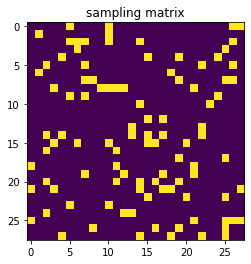

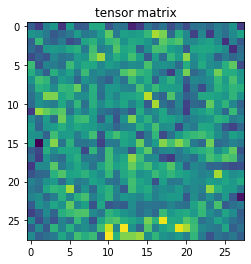

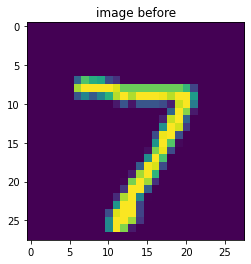

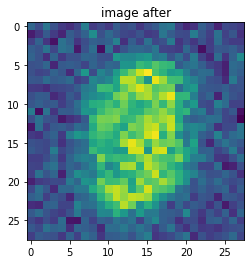

epoch :  0  with :  0.06655137240886688 test_loss  covery rate :  None %


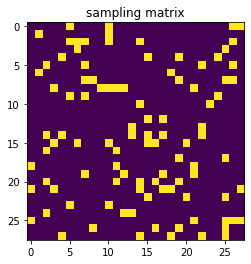

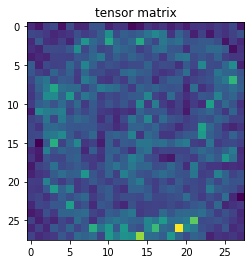

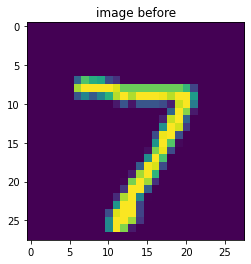

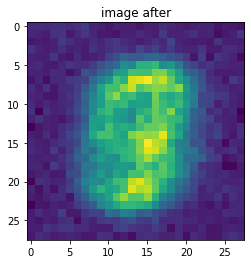

epoch :  0  with :  0.0807931050658226 test_loss  covery rate :  None %


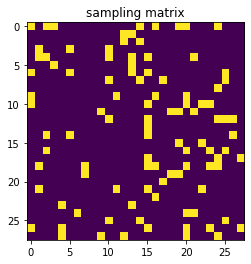

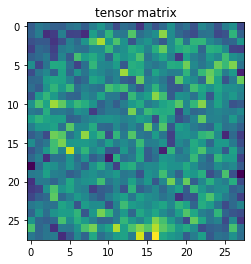

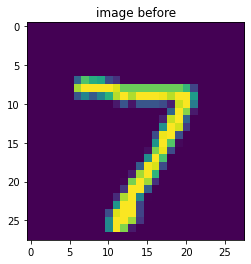

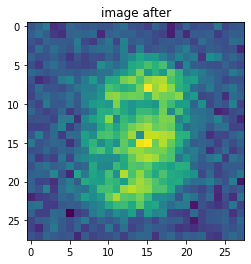

epoch :  0  with :  0.06652341783046722 test_loss  covery rate :  None %


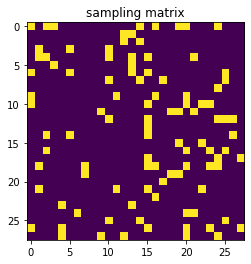

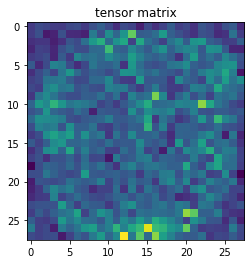

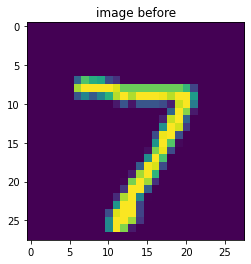

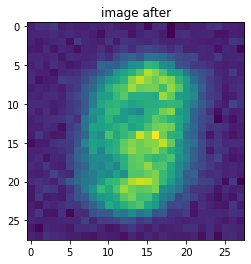

epoch :  0  with :  0.08135928213596344 test_loss  covery rate :  None %


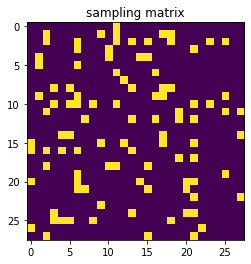

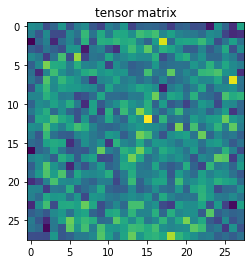

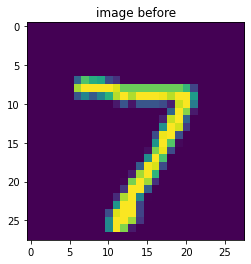

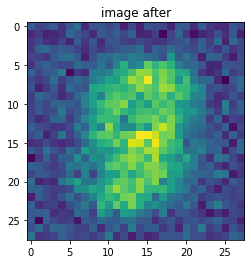

epoch :  0  with :  0.06663915514945984 test_loss  covery rate :  None %


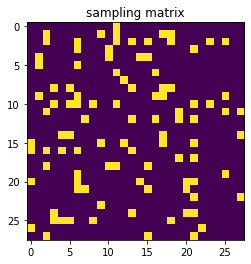

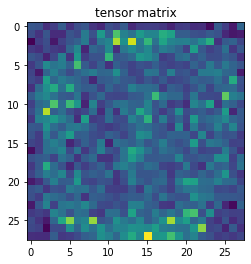

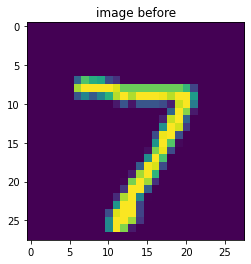

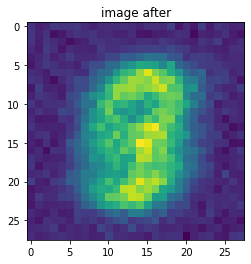

epoch :  0  with :  0.08074849843978882 test_loss  covery rate :  None %


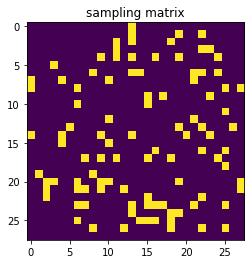

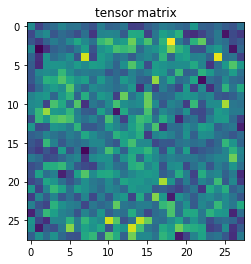

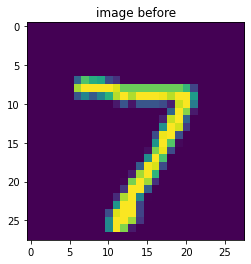

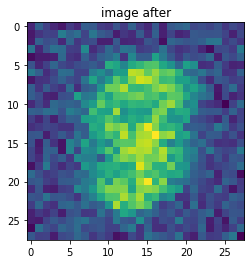

epoch :  0  with :  0.06638096272945404 test_loss  covery rate :  None %


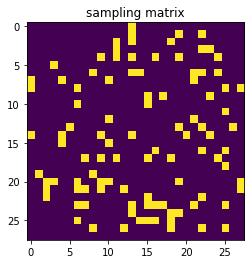

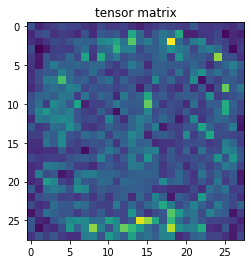

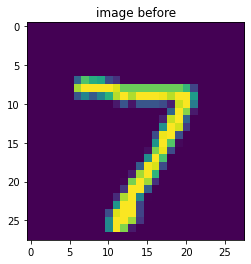

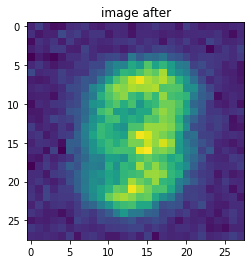

epoch :  0  with :  0.07933524996042252 test_loss  covery rate :  None %


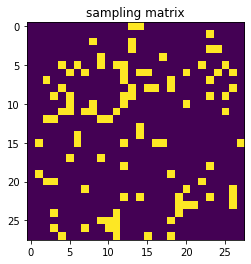

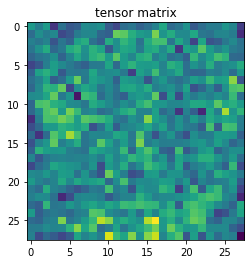

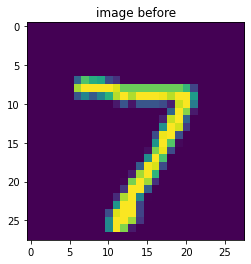

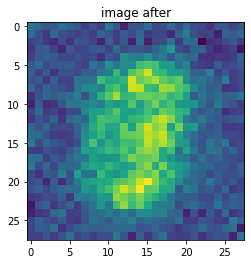

epoch :  0  with :  0.0664822906255722 test_loss  covery rate :  None %


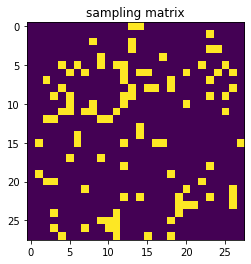

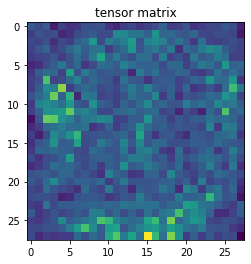

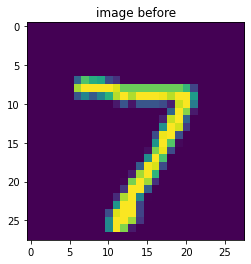

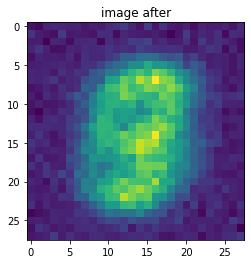

epoch :  0  with :  0.08048973977565765 test_loss  covery rate :  None %


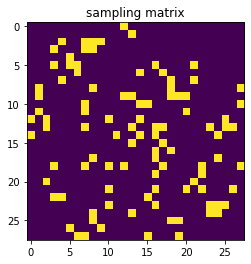

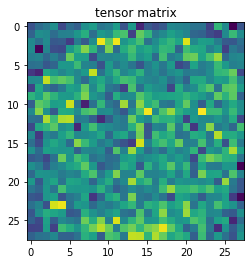

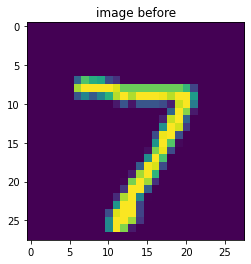

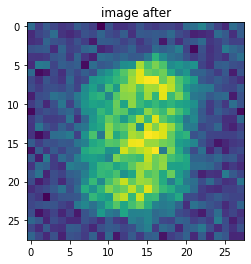

epoch :  0  with :  0.0667639672756195 test_loss  covery rate :  None %


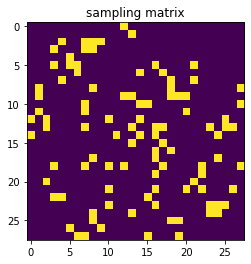

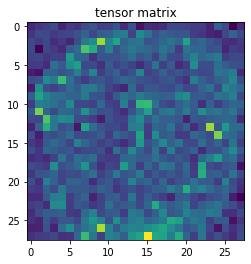

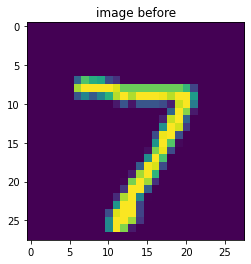

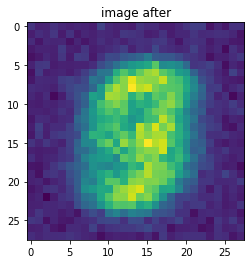

epoch :  0  with :  0.07875074446201324 test_loss  covery rate :  tensor(100.) %


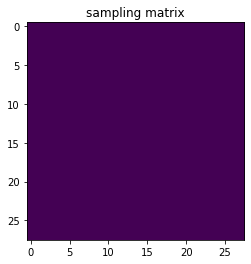

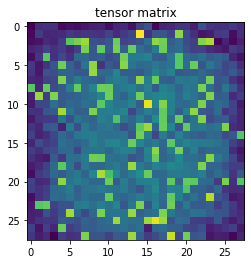

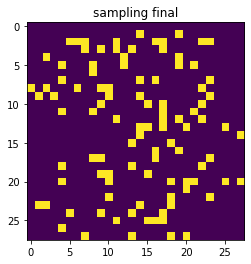

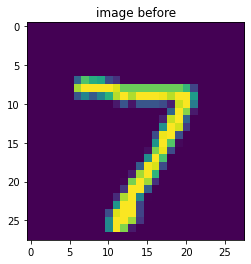

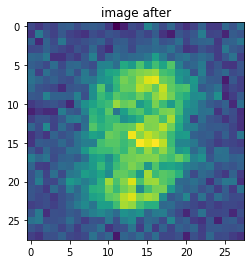

epoch :  0  with :  0.06657646596431732 test_loss  covery rate :  tensor(100.) %


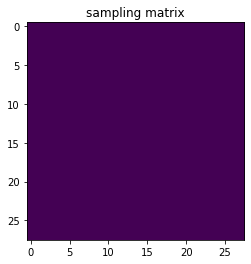

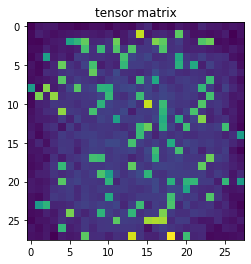

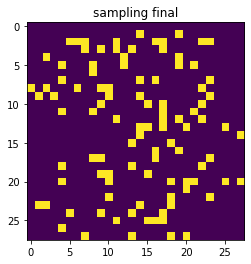

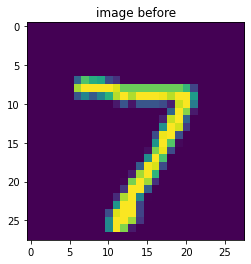

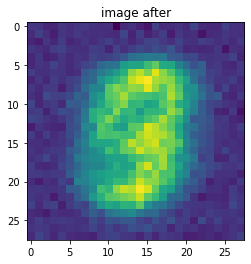

epoch :  0  with :  0.07844920456409454 test_loss  covery rate :  tensor(100.) %


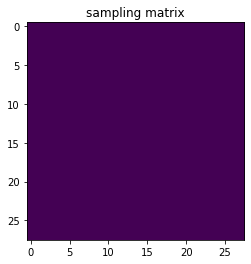

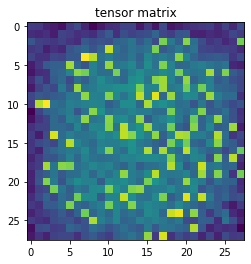

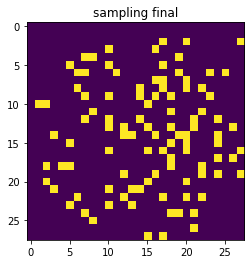

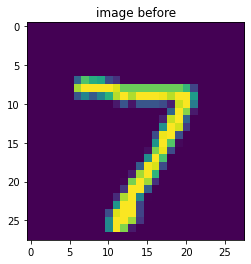

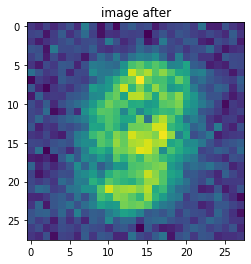

epoch :  0  with :  0.06632654368877411 test_loss  covery rate :  tensor(100.) %


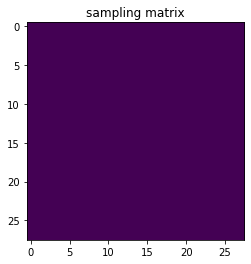

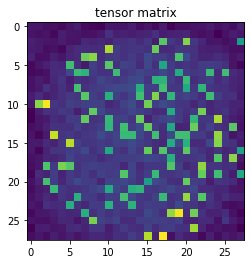

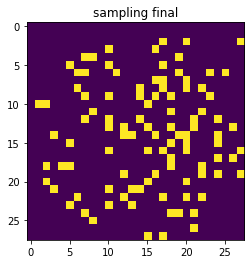

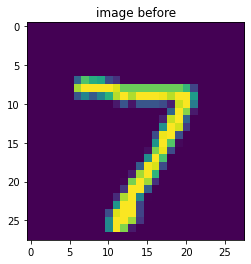

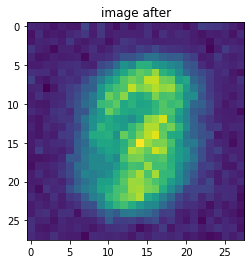

epoch :  0  with :  0.076875701546669 test_loss  covery rate :  tensor(100.) %


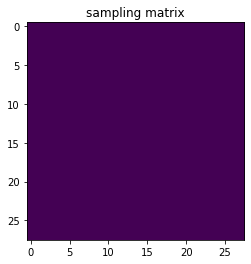

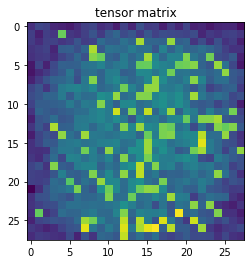

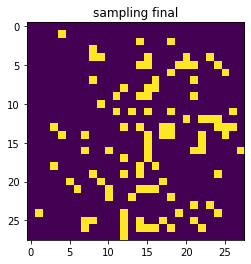

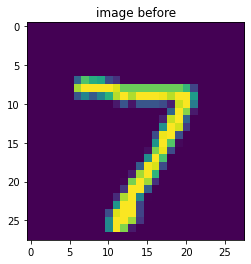

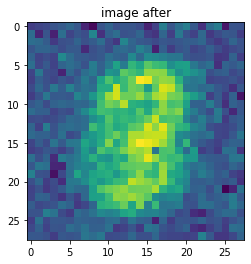

epoch :  0  with :  0.066068634390831 test_loss  covery rate :  tensor(100.) %


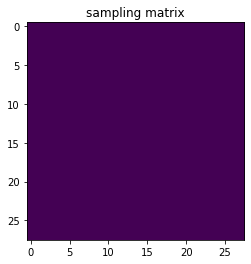

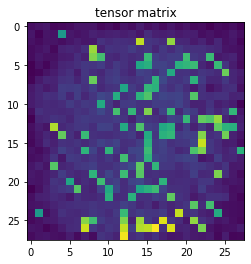

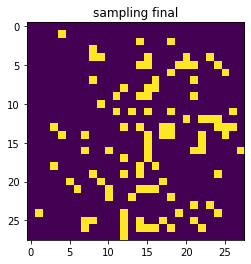

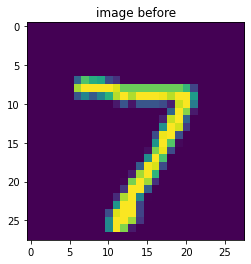

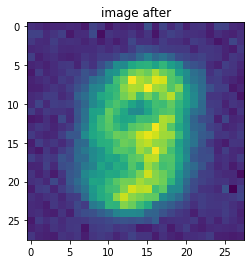

epoch :  0  with :  0.07998686283826828 test_loss  covery rate :  tensor(100.) %


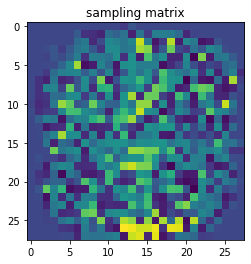

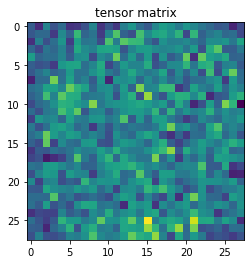

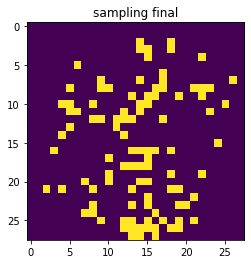

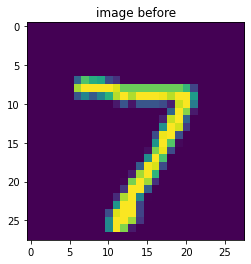

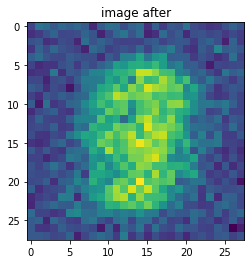

epoch :  0  with :  0.0664437785744667 test_loss  covery rate :  tensor(100.) %


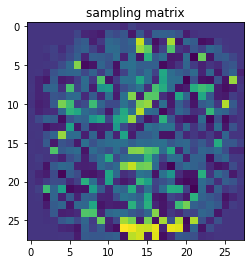

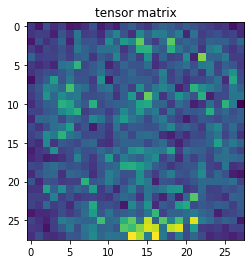

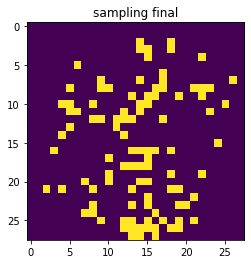

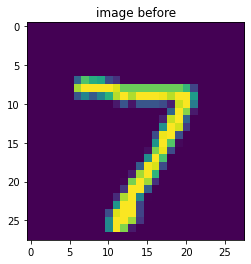

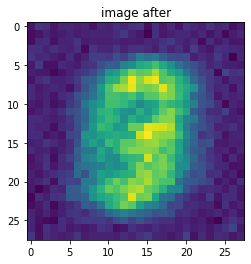

epoch :  0  with :  0.08016885817050934 test_loss  covery rate :  tensor(100.) %


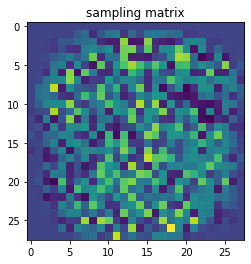

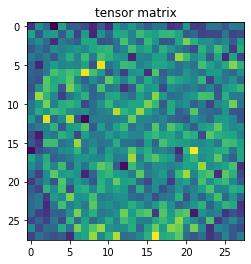

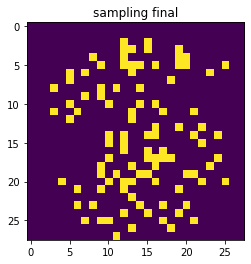

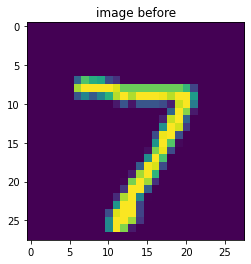

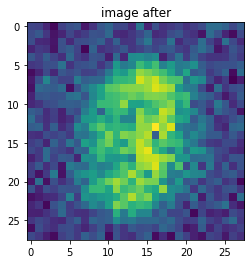

epoch :  0  with :  0.06639876961708069 test_loss  covery rate :  tensor(100.) %


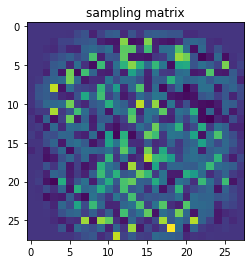

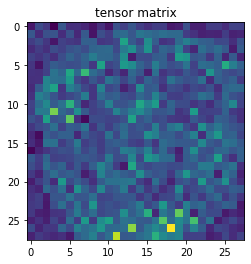

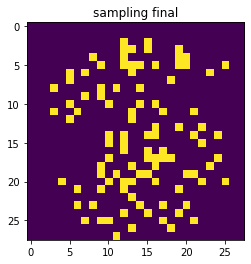

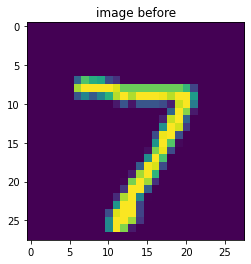

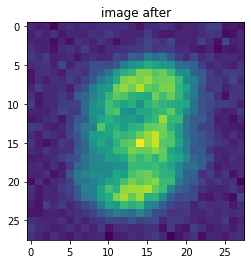

epoch :  0  with :  0.07605203986167908 test_loss  covery rate :  tensor(100.) %


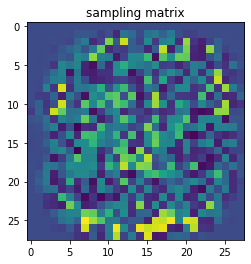

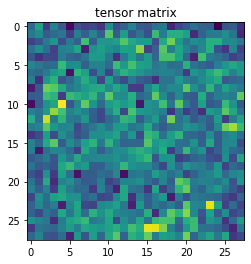

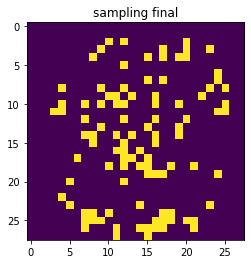

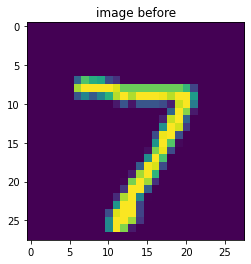

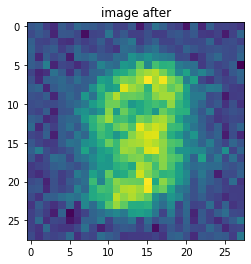

epoch :  0  with :  0.06587770581245422 test_loss  covery rate :  tensor(100.) %


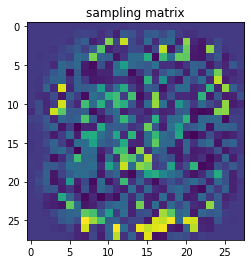

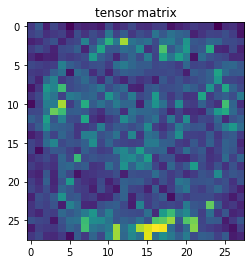

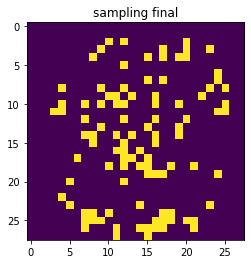

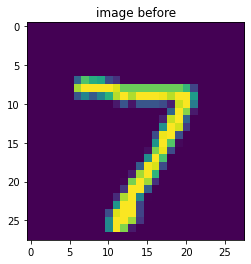

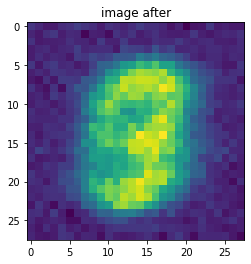

epoch :  0  with :  0.09241741895675659 test_loss  covery rate :  tensor(100.) %


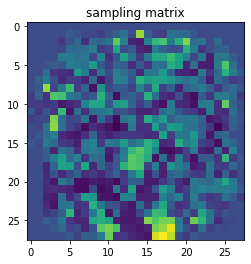

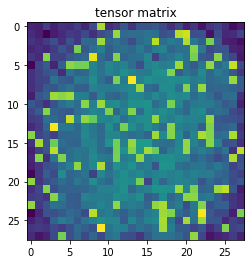

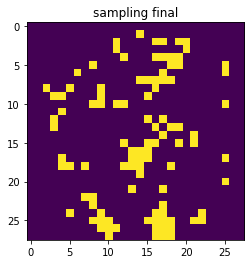

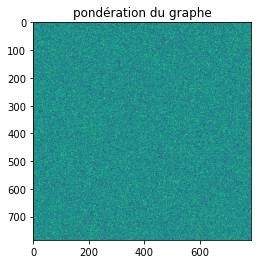

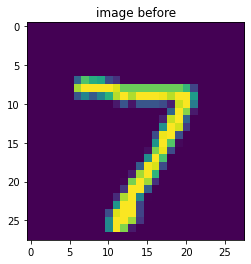

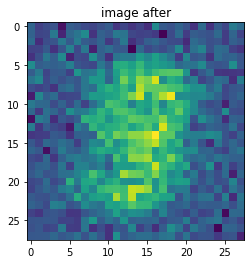

epoch :  0  with :  0.06769902259111404 test_loss  covery rate :  tensor(100.) %


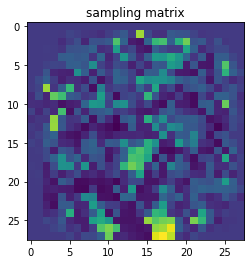

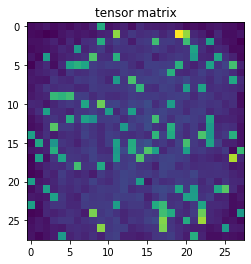

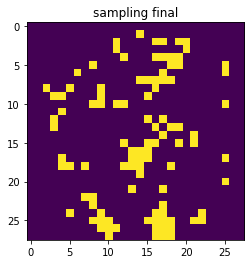

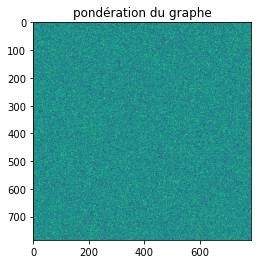

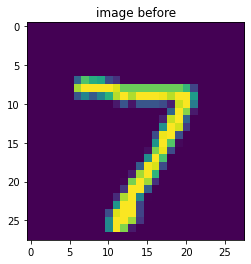

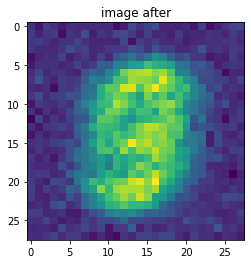

epoch :  0  with :  0.09011704474687576 test_loss  covery rate :  tensor(100.) %


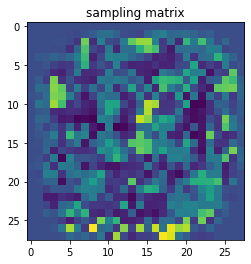

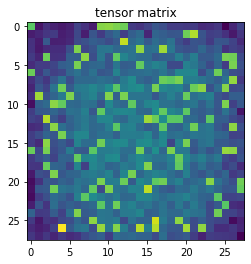

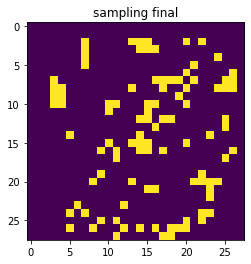

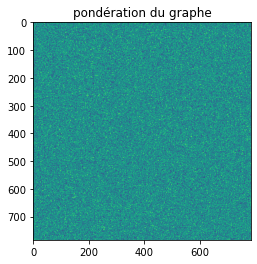

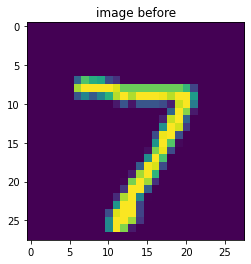

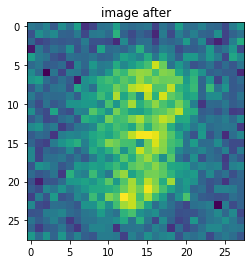

epoch :  0  with :  0.06730492413043976 test_loss  covery rate :  tensor(100.) %


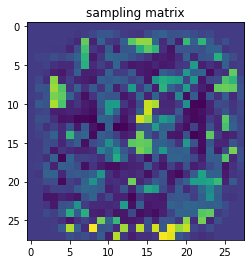

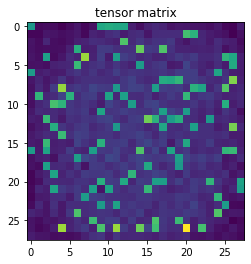

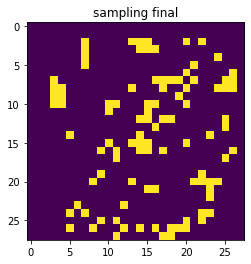

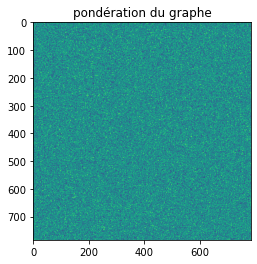

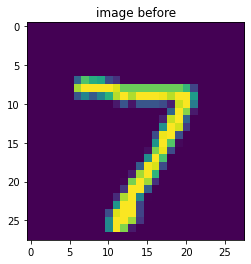

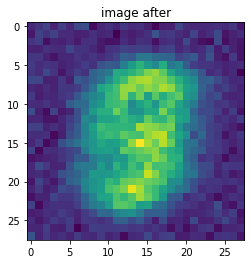

epoch :  0  with :  0.09236282110214233 test_loss  covery rate :  tensor(100.) %


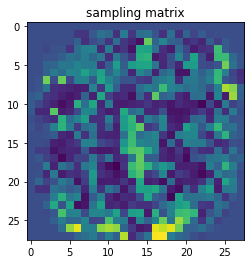

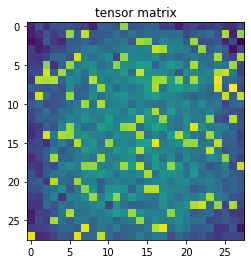

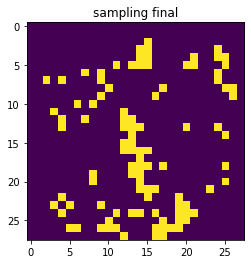

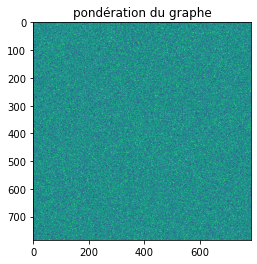

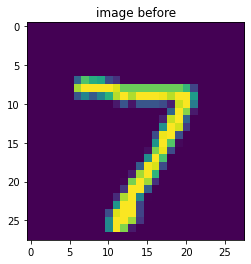

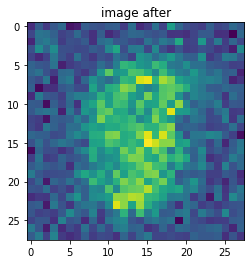

epoch :  0  with :  0.06774011254310608 test_loss  covery rate :  tensor(100.) %


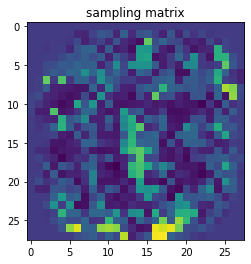

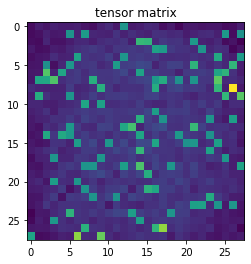

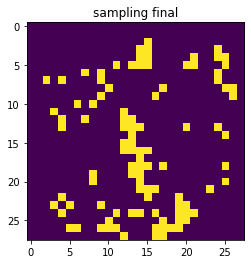

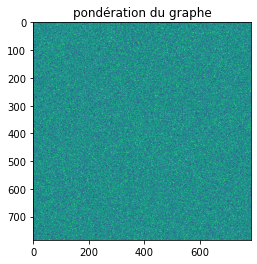

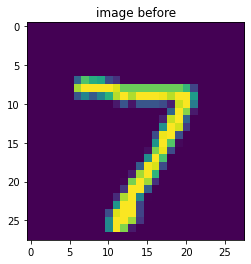

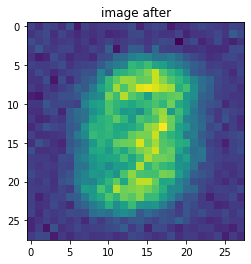

epoch :  0  with :  0.11417819559574127 test_loss  covery rate :  tensor(100.) %


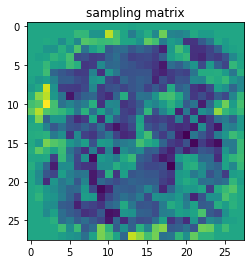

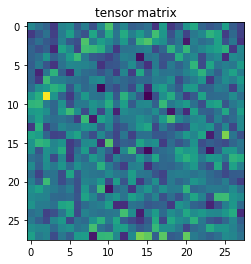

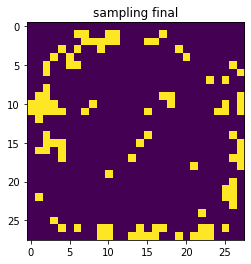

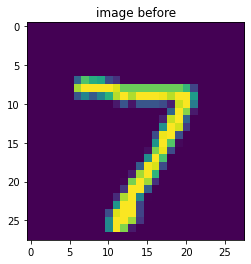

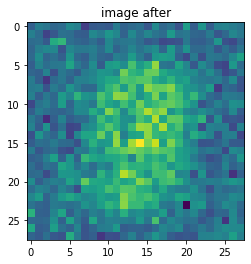

epoch :  0  with :  0.0685524120926857 test_loss  covery rate :  tensor(83.) %


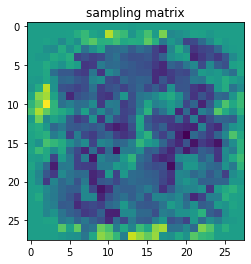

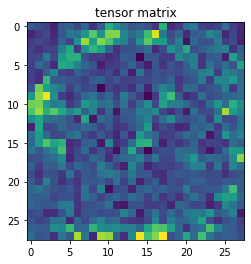

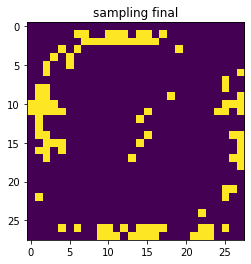

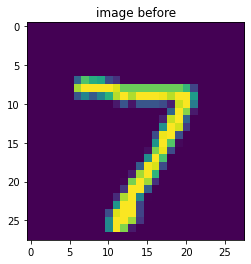

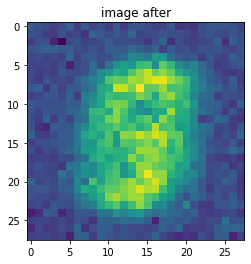

epoch :  0  with :  0.10818453878164291 test_loss  covery rate :  tensor(100.) %


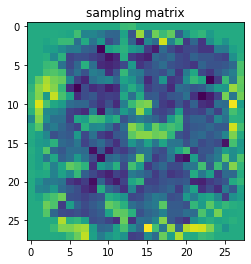

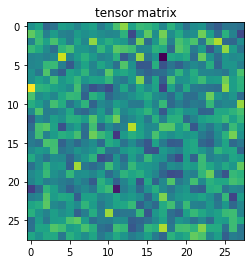

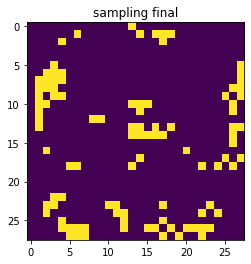

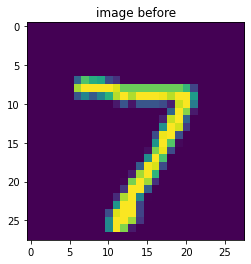

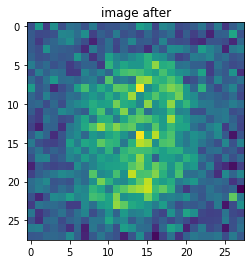

epoch :  0  with :  0.06841303408145905 test_loss  covery rate :  tensor(84.) %


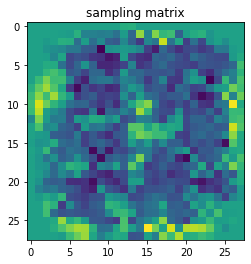

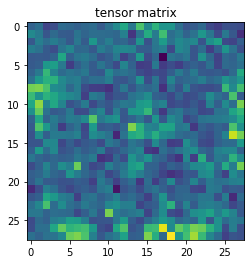

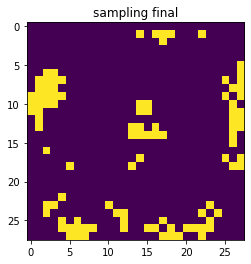

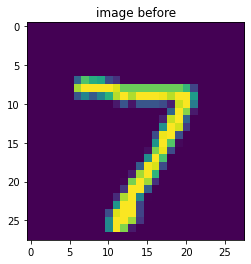

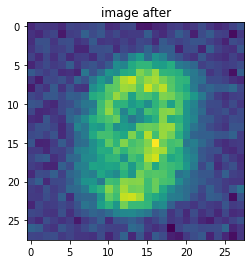

epoch :  0  with :  0.11663603782653809 test_loss  covery rate :  tensor(100.) %


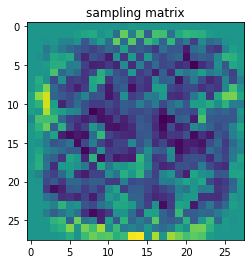

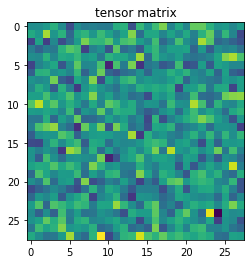

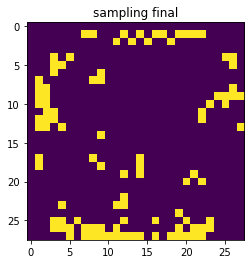

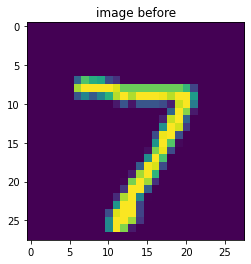

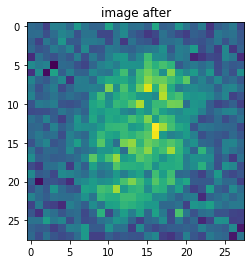

epoch :  0  with :  0.06860993057489395 test_loss  covery rate :  tensor(81.) %


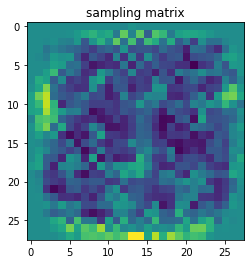

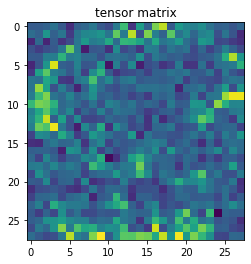

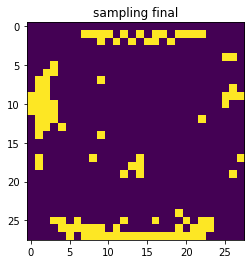

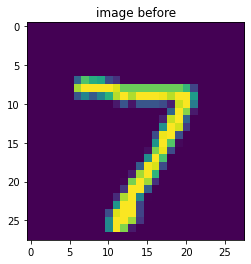

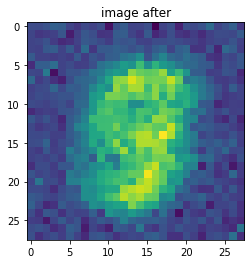

In [93]:
#Configure Device
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
main()